# Stock Price Prediction Using Random Forest

In this notebook, we will be exploring the performance of the random forest classifier on the S&P500 stock data.

## Notas

Preciso de 15 dias de dados antes de 2010 para calcular umas coisas, ou então removo aproximadamente 13 ou 14 colunas.

Sources:
 - [The Random Forest Model for Analyzing and Forecasting the US Stock Market in the Context of Smart Finance](https://arxiv.org/pdf/2402.17194)

In [46]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
import os
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import random
import math
import matplotlib.pyplot as plt
import yfinance as yf

# Data Preprocessing

In [47]:
df_apple = pd.read_csv('./csvs_processing/dropped_multiIndex/AAPL.csv')

df_apple.head()

,Date,AdjClose,Close,High,Low,Open,Volume
0,2010-01-04,6.447411,7.643214,7.660714,7.585000,7.622500,493729600
1,2010-01-05,6.458559,7.656429,7.699643,7.616071,7.664286,601904800
2,2010-01-06,6.355826,7.534643,7.686786,7.526786,7.656429,552160000
3,2010-01-07,6.344076,7.520714,7.571429,7.466071,7.562500,477131200
4,2010-01-08,6.386254,7.570714,7.571429,7.466429,7.510714,447610800


## Obtaining Recommended Features

<center>

![](./images/features_paper1.png)

</center>

This section of the notebook is dedicated to following mathematical formulas in order to generate financial metrics, which will be used to predict values **without violating the causality principle**.

 - **RSI (Relative Strength Index)**: The RSI measures the speed and change of price movements. It oscillates between 0 and 100 and is calculated over a specific period (e.g., 14 days).

<center>

$
RSI = 100 - \frac{100}{1 + RS}
$      

</center>

<center>

where

</center>

<center>

$
RS = \frac{\text{Average Gain over N periods}}{\text{Average Loss over N periods}}
$

</center>

In [48]:
def addRSI(df):    

    window_length = 14  # Standard Value
    
    # Calculate price differences
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate exponential moving averages of gains and losses
    avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
    avg_loss = loss.rolling(window=window_length, min_periods=1).mean()

    # Calculate RSI
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))


 - **Stochastic Oscillator**:
Measures the closing price relative to the price range over a period of time (e.g., 14 days).

<center>

$
\%K = \frac{\text{Close} - \text{Low}_N}{\text{High}_N - \text{Low}_N} \times 100
$

</center>


In [49]:
def addK(df):
    n = 14  # Look-back period
    df['%K'] = ((df['Close'] - df['Low'].rolling(n).min()) / (df['High'].rolling(n).max() - df['Low'].rolling(n).min())) * 100

 - **Williams %R**:
Similar to the stochastic oscillator but inverted and shifted.

<center>

$
\%R = \frac{\text{High}_N - \text{Close}}{\text{High}_N - \text{Low}_N} \times -100
$

</center>


In [50]:
def addR(df):
    n = 14
    highn_close = (df['High'].rolling(n).max() - df['Close'])
    highn_lown = (df['High'].rolling(n).max() - df['Low'].rolling(n).min())
    df['%R'] = (highn_close / highn_lown) * (-100)

 - **MACD (Moving Average Convergence Divergence)**:
Measures the difference between a fast and a slow exponential moving average (EMA).

In [51]:
def addMACD(df):
    fast_period = 12
    slow_period = 26
    signal_period = 9

    df['EMA_fast'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA_slow'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    df['MACD'] = df['EMA_fast'] - df['EMA_slow']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

 -  **Price Rate of Change (ROC)**:
Measures the percentage change in price over a given time.

<center>

$
ROC = \frac{\text{Close}_t - \text{Close}_{t-n}}{\text{Close}_{t-n}} \times 100
$

</center>


In [52]:
def addROC(df, period):
    n = period
    df['ROC'] = (df['Close'] - df['Close'].shift(n)) / df['Close'].shift(n) * 100

 - **On-Balance Volume (OBV)**:
Measures buying and selling pressure using volume.

In [53]:
def addOBV(df):
    df['Direction'] = df['Close'].diff().apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df['OBV'] = (df['Direction'] * df['Volume']).cumsum()

### Adding Paper Recommended Features

In order to facilitate adding features to any dataframe, we decided to build this function, which already **removes NaN values automatically**. We have 2 different options to do so:
 - Removing the first 14 rows of the dataframe, as they are entered due to the **look-back period**, which is never higher than 14.
 - Removing only 2 rows, but deleting the `%K`, `%R` and `ROC` columns entirely.

We decided to implement this possibility, in case dimentionality is a problem in the future.

In [54]:
def addFeatures(df, rows=-1):
    addRSI(df)
    addK(df)
    addR(df)
    addMACD(df)
    addROC(df, 30)
    addOBV(df)

    # Removes first determined rows of the dataset 
    if rows > 0: df.drop(index=range(0, 30), inplace=True)

    # Removes first 2 rows of the dataset, and the `%K`, `%R` and `ROC` columns
    else: 
        df.drop(index=range(0, 2), inplace=True)
        df.drop(columns=['ROC','%K', '%R'], inplace=True)

In [55]:
addFeatures(df_apple, rows=14)

df_apple.head(15)

,Date,AdjClose,Close,High,Low,Open,Volume,RSI,%K,%R,EMA_fast,EMA_slow,MACD,Signal_Line,ROC,Direction,OBV
30,2010-02-17,6.102161,7.233929,7.296786,7.173571,7.292500,436396800,44.352624,80.655823,-19.344177,7.125954,7.208847,-0.082892,-0.123026,-5.354882,-1,2659932800
31,2010-02-18,6.113606,7.247500,7.281786,7.175714,7.201071,422825200,54.669073,90.184888,-9.815112,7.144654,7.211710,-0.067056,-0.111832,-5.340987,1,3082758000
32,2010-02-19,6.075648,7.202500,7.257143,7.182500,7.209286,415469600,64.556210,80.386299,-19.613701,7.153553,7.211028,-0.057475,-0.100960,-4.408215,-1,2667288400
33,2010-02-22,6.037990,7.157857,7.232143,7.113929,7.226429,390563600,59.006024,71.099519,-28.900481,7.154215,7.207089,-0.052874,-0.091343,-4.824766,-1,2276724800
34,2010-02-23,5.936765,7.037857,7.190357,6.989643,7.142857,575094800,51.774102,46.136716,-53.863284,7.136314,7.194553,-0.058240,-0.084722,-7.038397,-1,1701630000
35,2010-02-24,6.045220,7.166429,7.194286,7.065714,7.079643,460566400,52.099884,72.882718,-27.117282,7.140947,7.192470,-0.051523,-0.078082,-4.497645,1,2162196400
36,2010-02-25,6.085590,7.214286,7.245000,7.031786,7.049286,665126000,67.635582,82.838061,-17.161939,7.152230,7.194086,-0.041856,-0.070837,-2.753699,1,2827322400
37,2010-02-26,6.164521,7.307857,7.327500,7.214286,7.227857,507460800,66.703153,95.076104,-4.923896,7.176173,7.202514,-0.026341,-0.061938,-2.862564,1,3334783200
38,2010-03-01,6.296177,7.463929,7.482143,7.337500,7.348214,550093600,74.417086,96.696990,-3.303010,7.220443,7.221878,-0.001435,-0.049837,-0.210086,1,3884876800
39,2010-03-02,6.291959,7.458929,7.529643,7.419286,7.497500,566546400,72.194948,88.193257,-11.806743,7.257133,7.239437,0.017696,-0.036331,1.417964,-1,3318330400


---

## Introduction to Model Development

In [56]:
# Convert Date to datetime and sort by Date
df_apple['Date'] = pd.to_datetime(df_apple['Date'])
df_apple = df_apple.sort_values(by='Date')

# Removing adjusted close from training data
df_apple = df_apple.drop(columns=['AdjClose'])

Because we cannot pass `datetime` objects into the random forest, we need to create new columns to represent day, month and year, thus preserving sequential importance.

In [57]:
# Extract temporal features
df_apple['Day'] = df_apple['Date'].dt.day
df_apple['Month'] = df_apple['Date'].dt.month
df_apple['Year'] = df_apple['Date'].dt.year

In [58]:
df_apple.head()

,Date,Close,High,Low,Open,Volume,RSI,%K,%R,EMA_fast,EMA_slow,MACD,Signal_Line,ROC,Direction,OBV,Day,Month,Year
30,2010-02-17,7.233929,7.296786,7.173571,7.292500,436396800,44.352624,80.655823,-19.344177,7.125954,7.208847,-0.082892,-0.123026,-5.354882,-1,2659932800,17,2,2010
31,2010-02-18,7.247500,7.281786,7.175714,7.201071,422825200,54.669073,90.184888,-9.815112,7.144654,7.211710,-0.067056,-0.111832,-5.340987,1,3082758000,18,2,2010
32,2010-02-19,7.202500,7.257143,7.182500,7.209286,415469600,64.556210,80.386299,-19.613701,7.153553,7.211028,-0.057475,-0.100960,-4.408215,-1,2667288400,19,2,2010
33,2010-02-22,7.157857,7.232143,7.113929,7.226429,390563600,59.006024,71.099519,-28.900481,7.154215,7.207089,-0.052874,-0.091343,-4.824766,-1,2276724800,22,2,2010
34,2010-02-23,7.037857,7.190357,6.989643,7.142857,575094800,51.774102,46.136716,-53.863284,7.136314,7.194553,-0.058240,-0.084722,-7.038397,-1,1701630000,23,2,2010


In [59]:
# Train with 2010 - 2023
train_data = df_apple[(df_apple['Date'] >= '2010-01-01') & (df_apple['Date'] < '2024-01-01')]

# Test with January 2024
test_data = df_apple[(df_apple['Date'] >= '2024-01-01') & (df_apple['Date'] < '2024-02-01')]

# Separates train_data into X and y
X_train = train_data.drop(columns=['Volume','Date','Close', 'High', 'Low', 'Open'])
y_train = train_data['Close']

In [60]:
X_train.head()

,RSI,%K,%R,EMA_fast,EMA_slow,MACD,Signal_Line,ROC,Direction,OBV,Day,Month,Year
30,44.352624,80.655823,-19.344177,7.125954,7.208847,-0.082892,-0.123026,-5.354882,-1,2659932800,17,2,2010
31,54.669073,90.184888,-9.815112,7.144654,7.211710,-0.067056,-0.111832,-5.340987,1,3082758000,18,2,2010
32,64.556210,80.386299,-19.613701,7.153553,7.211028,-0.057475,-0.100960,-4.408215,-1,2667288400,19,2,2010
33,59.006024,71.099519,-28.900481,7.154215,7.207089,-0.052874,-0.091343,-4.824766,-1,2276724800,22,2,2010
34,51.774102,46.136716,-53.863284,7.136314,7.194553,-0.058240,-0.084722,-7.038397,-1,1701630000,23,2,2010


In [61]:
y_train.head()

30    7.233929
31    7.247500
32    7.202500
33    7.157857
34    7.037857
Name: Close, dtype: float64

In [62]:
# Separates test_data into X and y
X_test = test_data.drop(columns=['Volume','Date','Close', 'High', 'Low', 'Open'])
y_test = test_data['Close']

# Keep for reference during performance analysis
y_test_dates = test_data['Date']  

In [63]:
X_test.head()

,RSI,%K,%R,EMA_fast,EMA_slow,MACD,Signal_Line,ROC,Direction,OBV,Day,Month,Year
3522,31.663452,11.125241,-88.874759,192.642575,191.860181,0.782394,2.096536,-2.145384,-1,16138533900,2,1,2024
3523,24.387836,5.064899,-94.935101,191.351410,191.296464,0.054946,1.688218,-2.867838,-1,16080119400,3,1,2024
3524,8.867228,5.496261,-94.503739,189.898886,190.601171,-0.702285,1.210118,-4.983021,-1,16008135800,4,1,2024
3525,7.864614,5.540289,-94.459711,188.557518,189.903306,-1.345788,0.698936,-4.962236,-1,15945832500,5,1,2024
3526,24.905980,30.782416,-69.217584,188.096361,189.581579,-1.485219,0.262105,-3.005593,1,16004977000,8,1,2024


In [64]:
y_test_dates.head()

3522   2024-01-02
3523   2024-01-03
3524   2024-01-04
3525   2024-01-05
3526   2024-01-08
Name: Date, dtype: datetime64[ns]

In [65]:
y_test.head()

3522    185.639999
3523    184.250000
3524    181.910004
3525    181.179993
3526    185.559998
Name: Close, dtype: float64

---

## Random Forest: Model Inherent Problem

Random Forests require the same input as they were trained on. The model is trained on infromation derived from closing prices, so that means that if we wish to predict closing prices for January 2024, we would already need to know the closing prices for January 2024. This violates the concept of prediction, which is to predict future values based on past values. 

We must get creative in order to find a solution!

We already know RF's are not built to handle sequential data. In order to show relevance regarding time series, we have already **implemented 3 columns to represent dates**.

However, the most prominent issue is that we currently need future data to predict said future data.

In order to mitigate this problem, we decided to split the training and prediction process into very specific steps:

 - Get financial metrics for 13 years
 
 - Use information available online to create functions that emulate patterns followed by each metric, based on statistics
 
 - Use those functions to determine values those metrics are likely to show in January, based on 13 years of data

 - Create a new test dataframe containing approximate values
 
 - Fit to a final, independent model to predict the stock price for January 2024

In order to do this, we have also applied **MinMax scaling** and **binning** to the dataframe.

In [66]:
df_apple = pd.read_csv('./csvs_processing/dropped_multiIndex/AAPL.csv')

In [67]:
def apply_minmax_scaling(train_df, test_df, columns_to_scale):
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler on the training data and transform it
    train_scaled = train_df.copy()  
    train_scaled[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])

    # Transform the test data using the same scaler (tests inside the same interval)
    test_scaled = test_df.copy()  
    test_scaled[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

    return train_scaled, test_scaled

In order to aid the classification task, due to the presence of floating point values, we decided to implement a form of **binning**, based on the **Sturges' Rule**:
<br>
<center>

$
\text{Number of bins} = \lceil \log_2(N) + 1 \rceil
$

</center>

In [68]:
# Applies a type of binning to the train and test dataframes 
def apply_interval_division(train_df, test_df, columns_to_divide, separate=False, slices=10, showIntervals=False):
    tr_df = train_df.copy()
    te_df = test_df.copy()
    if separate:
        for c in columns_to_divide:
            min_train, max_train = train_df[c].min(), train_df[c].max()
            min_test, max_test = test_df[c].min(), test_df[c].max()
    else:

        for c in columns_to_divide:
            df_min = min(train_df[c].min(), test_df[c].min())
            df_max = max(train_df[c].max(), test_df[c].max())

            # Creates intervals based on the Sturges' Rule
            max_intervals = max(math.ceil(math.log(len(c),2)), slices)
            bin_edges = np.linspace(df_min, df_max, max_intervals)

            if showIntervals:
                intervals = [
                f"[{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f})" if (i < len(bin_edges) - 2) 
                else f"[{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f}]"
                for i in range(len(bin_edges) - 1)]
                print(intervals, len(intervals))

            # Digitize the train and test data into bins
            # If we use labels=False -> automatically transforms the intervals into integers
            tr_df[c] = pd.cut(train_df[c], bins=bin_edges, labels=False, include_lowest=True)
            te_df[c] = pd.cut(test_df[c], bins=bin_edges, labels=False, include_lowest=True)

    return tr_df, te_df


## Predicting Metrics

In [69]:
def predictMetric(train_dataframe, test_dataframe, target):

    # Fill missing values (NaNs) with the median of the respective column (prevents errors)
    train_dataframe[['Day', 'Month', 'Year', target]] = train_dataframe[['Day', 'Month', 'Year', target]].fillna(train_dataframe[['Day', 'Month', 'Year', target]].median())
    test_dataframe[['Day', 'Month', 'Year']] = test_dataframe[['Day', 'Month', 'Year']].fillna(test_dataframe[['Day', 'Month', 'Year']].median())

    # Uses date to predict
    X_train = train_dataframe[['Day','Month','Year']] 
    y_train = train_dataframe[target]  
    
    X_test = test_dataframe[['Day','Month','Year']]
    
    # Best settings determined in the genralization chapter
    rf = RandomForestRegressor(n_estimators=50, min_samples_split=5, min_samples_leaf=2, 
                              max_features='sqrt', max_depth=20, bootstrap=True)
    
    rf.fit(X_train, y_train)
    
    # Predictst for January 2024
    test_dataframe[target] = rf.predict(X_test)

## Splitting Predicted Data

In [70]:
def split_data(df, target='Close', colsRemove=['Date','Close', 'High', 'Low', 'Open','AdjClose','Volume'], 
               scale=False, intervals=False, showIntervals=False):
    
    # Convert Date to datetime and sort by Date
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')

    # Extract temporal features
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year

    # 2010 - 2023
    train_data = df[(df['Date'] >= '2023-01-01') & (df['Date'] < '2024-01-01')]

    # Test with January 2024
    test_data = df[(df['Date'] >= '2024-01-01') & (df['Date'] < '2024-02-01')]

    metrics_to_predict = ['RSI','EMA_fast','EMA_slow','MACD','Signal_Line','Direction','OBV']

    #print(train_data.head())
    #print(test_data.head())

    for metric in metrics_to_predict:
        predictMetric(train_data, test_data, metric)

    minmax_cols = ['RSI','EMA_fast','EMA_slow','MACD','Signal_Line','Direction','OBV','Close']

    if scale: train_data, test_data = apply_minmax_scaling(train_data, test_data, minmax_cols)

    # Closing price must not be placed into intervals to preserve behaviour
    if intervals: train_data, test_data = apply_interval_division(train_data, test_data, metrics_to_predict,showIntervals)

    #print(train_data.head())
    #print(test_data.head())

    # Separates train_data into X and y
    X_train = train_data.drop(columns=colsRemove, errors='ignore')
    y_train = train_data[target]

    # Separates test_data into X and y
    X_test = test_data.drop(columns=colsRemove, errors='ignore')
    y_test = test_data[target]

    # Keep for reference during performance analysis
    y_test_dates = test_data['Date']  

    return X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data

In [71]:
# Combine all functions
def preprocess_and_split(df, target='Close', colsRemove=['Date','Close', 'High', 'Low', 'Open','AdjClose','Volume'], 
                         rows=False, scale=False, intervals=False, showIntervals=False, features=True):
    
    df_preprocess = df.copy()

    addFeatures(df_preprocess, rows)
    
    X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data = split_data(df_preprocess, target, colsRemove, scale, intervals, showIntervals)

    return X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data

In [72]:
warnings.filterwarnings('ignore')
X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data = preprocess_and_split(df_apple,scale=False,intervals=False)


Because the values are all standardized to MinMax scaling, we can split them into easily comprehensible intervals. The number of intervals is modifiable.

The code above also automatically transforms each interval into an integer.

---

In [73]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=45)
model.fit(X_train, y_train)

# Predict for January 2024
predictions = model.predict(X_test)

# Create dataframe with results
results = pd.DataFrame({'Date': y_test_dates, 'Predicted_Close': predictions})

In [74]:
results.head()

,Date,Predicted_Close
3522,2024-01-02,132.060443
3523,2024-01-03,131.326221
3524,2024-01-04,131.159777
3525,2024-01-05,130.076888
3526,2024-01-08,132.493555


In [75]:
if 'Close' in test_data.columns:
    y_test = test_data['Close']
    rmse = root_mean_squared_error(y_test, predictions)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 50.07816196166583


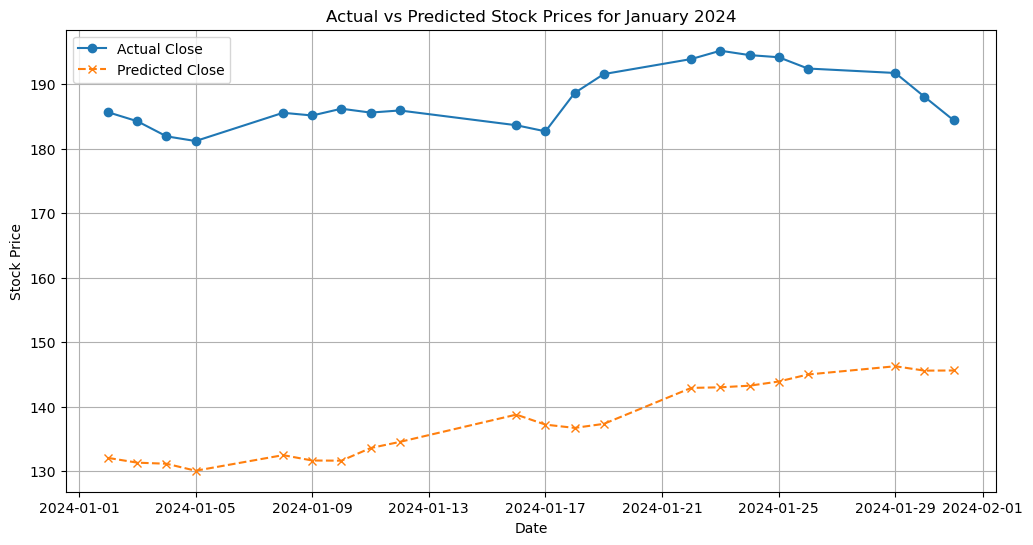

In [76]:
plt.figure(figsize=(12, 6))

# Plot real prices
plt.plot(test_data['Date'], test_data['Close'], label='Actual Close', marker='o')

# Plot predicted prices
plt.plot(y_test_dates, predictions, label='Predicted Close', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices for January 2024')
plt.legend()
plt.grid(True)
plt.show()


As we have demonstrated in the report, all stock prices generaly follow the GSPC. This means that most of their patterns are quite similar to each other, meaning that the best RF settings for a small sample of different stocks should be the best settings overall.

In [77]:
def optimize_rf_hyperparameters(data_folder, num_samples=50):

    results = []
    
    param_dist = {
        'n_estimators': [50, 100, 150, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Randomly choose 50 files (10% of total files)
    csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    sampled_files = random.sample(csv_files, min(num_samples, len(csv_files)))

    for file_name in tqdm(sampled_files, desc="Processing CSV files"):
        df = pd.read_csv(os.path.join(data_folder, file_name))
        
        X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data = preprocess_and_split(df, scale=True, intervals=False)
    
        rf = RandomForestRegressor()
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=20,  # Number of random combinations to test
            cv=3,       
            n_jobs=-1,  # Use all available cores
            verbose=0,  
        )

        try:
            random_search.fit(X_train, y_train)
        except Exception as e:
            print(f"Error in processing CSV file: {file_name}")
            print(f"Error details: {str(e)}")

        best_params = random_search.best_params_
        best_model = random_search.best_estimator_
        predictions = best_model.predict(X_test)
        rmse = root_mean_squared_error(y_test, predictions)

        # Each parameter represents a column
        result = {'file_name': file_name, 'rmse': rmse}
        for param, value in best_params.items():
            result[param] = value

        # Save best results
        results.append(result)

    results_df = pd.DataFrame(results)
    results_df.to_csv('./pickle_jar/rf_tuning_results.csv', index=False)
    print("Randomized Search complete!")

    return results_df

Simply change this cell to python in order to run the code.

```py
results_df = optimize_rf_hyperparameters('./clean_csvs', 50)
```

In [78]:
def convertNp(val):
    if isinstance(val, np.int64): return int(val)
    elif isinstance(val, np.bool_): return bool(val)
    elif isinstance(val, np.float64): return float(val)
    return val

In [79]:
results_df = pd.read_csv('./pickle_jar/rf_tuning_results.csv')

results_df = results_df.where(pd.notnull(results_df), None)

# Identify the most common value for each column (should be the overall best)
most_common_params = {}
for column in results_df.columns[2:]: 
    most_common_value = results_df[column].mode()
    
    if not most_common_value.empty:
        most_common_params[column] = convertNp(most_common_value[0])
    else:
        most_common_params[column] = None  


# Create the final dictionary with the best parameters
print("Best Hyperparameters: \n")
print(most_common_params)

results_df.head()

Best Hyperparameters: 

{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20.0, 'bootstrap': True}


,file_name,rmse,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
0,NOC.csv,0.050204,50,2,1,log2,30.0,False
1,PH.csv,0.379378,150,2,2,log2,10.0,True
2,RVTY.csv,0.148504,50,10,1,sqrt,30.0,False
3,F.csv,0.055861,50,2,4,sqrt,NaN,True
4,GL.csv,0.024587,200,2,2,sqrt,30.0,True


## Generalization

Now that we have the best parameters regarding our datasets, we can generalize predictions and buy signals.

However, we will only be creating the function to do so, since we could not obtain results good enough for comparison with LSTM prediction.

Aditionally, we will also implement some changes which were professor suggestions, as well as a few considerations.

In [80]:
X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data = preprocess_and_split(df_apple)

In [81]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=50, min_samples_split=5, min_samples_leaf=2, 
                              max_features='sqrt', max_depth=20, bootstrap=True)
model.fit(X_train, y_train)

# Predict for January 2024
predictions = model.predict(X_test)

# Create dataframe with results
results = pd.DataFrame({'Date': y_test_dates, 'Predicted_Close': predictions})

#### Feature Importance

In [82]:
# Extracting feature importance
importance = model.feature_importances_
feature_names = X_test.columns
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
2,EMA_slow,0.343982
1,EMA_fast,0.282886
6,OBV,0.161344
8,Month,0.119136
4,Signal_Line,0.036618
3,MACD,0.031687
0,RSI,0.018442
7,Day,0.005562
5,Direction,0.000343
9,Year,0.000000


As expected, the RF model is not takin into account the 'Year' column as being important. This could explain why the price inflation is not correctly captured, even if the model is capable of correctly predicting the changes' patterns:

 - Model is not correctly associating year increment with rise in price
 - Correctly detects relative changes in pattern, incorrectly assigns the absolute values

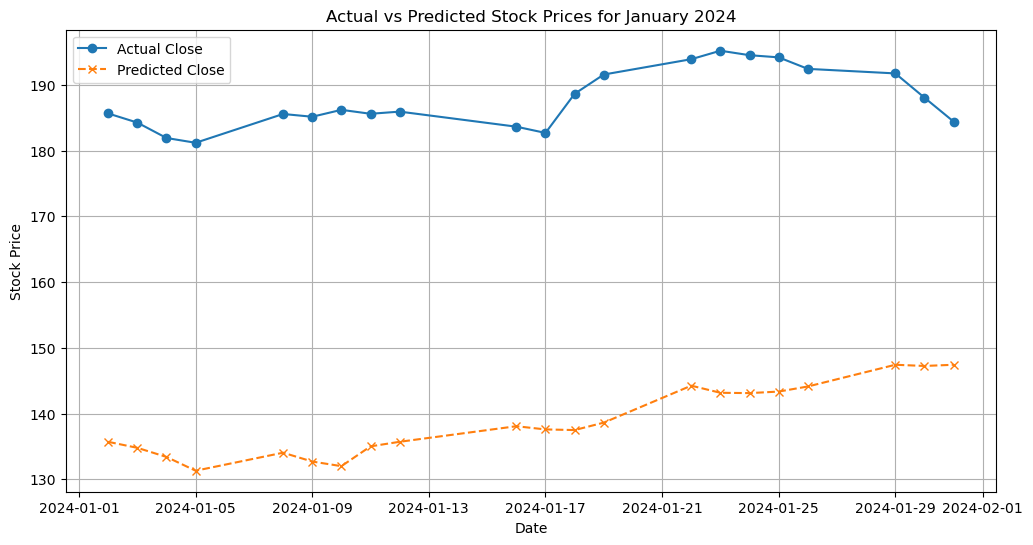

In [83]:
plt.figure(figsize=(12, 6))

# Plot real prices
plt.plot(test_data['Date'], test_data['Close'], label='Actual Close', marker='o')

# Plot predicted prices
plt.plot(y_test_dates, predictions, label='Predicted Close', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices for January 2024')
plt.legend()
plt.grid(True)
plt.show()


### All 500 Companies + Sector Column

In this section, we decided to **concatenate every csv** file, as well as create new `Ticker` and `Sector` columns, in order to ascertain whether it will hinder or improve model performance.

The code below implements the following logic:
 - Loop through the directory containing every tangible file
 - Apply our automatic feature extraction to each file
 - Extract each company's sector using the `yfinance` module
 - Create `Ticker` and `Sector` columns
 - Populate those columns with the data obtained
 - Create new `sp500_sectors.csv` file and store it in `pickle_jar`

In [84]:
def get_sp500_tickers():
    # Downloads the table from Wikipedia
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url)[0]
    tickers = table['Symbol'].tolist()
    
    # Remove any invalid ticker symbols if necessary
    tickers = [ticker.replace('.', '-') for ticker in tickers]  # For Yahoo Finance compatibility
    return tickers

In [85]:
def processSector(df, ticker):
    # Apply our feature extractor
    addFeatures(df, rows=14)

    # Debug1
    if (df.isnull().values.any())>0: 
        print("Has Null is ", df.isnull().values.any(), "for", ticker)

    # Creates and adds values to 'Ticker' column for df
    df["Ticker"] = ticker

    # Checks if sector is available in yfinance and places it inside 'Sector' column
    try:
        ticker_data = yf.Ticker(ticker)
        sector = ticker_data.info.get('sector', None)
        if sector == None: print(f"{ticker}'s Sector is None. Delete or fix.")
    except Exception as e:
        print(f"Sector information not available for {ticker}. Skipping sector assignment.")
    
    df["Sector"] = sector


    return df

In [86]:
tickers = get_sp500_tickers()
tickers.sort()
len(tickers)

503

In [87]:
clean_directory = './csvs_processing/dropped_multiIndex/'
save_directory = './csvs_processing/sectors/'

In [88]:
def createSectorSP500(tickers, clean_dir, save_dir):

    # Initialize the main dataframe
    clean_file_path = os.path.join(clean_dir, f"{tickers[0]}.csv")
    if os.path.exists(clean_file_path):
        df = pd.read_csv(clean_file_path)
        df = processSector(df, tickers[0])
        sp500_sectors = df.copy()

        # Create sp500_sectors.csv file 
        save_path = os.path.join("./pickle_jar/", "sp500_sectors.csv")
        sp500_sectors.to_csv(save_path, index=False)
    else:
        print(f"File for {tickers[0]} not found in {clean_dir}. Skipping...")


    # Iterate over every tangible file
    for ticker in tqdm(tickers[1:], desc="Processing Tickers", unit="ticker"):
        clean_file_path = os.path.join(clean_dir, f"{ticker}.csv")

        if os.path.exists(clean_file_path):

            # Creates Dataframe
            df = pd.read_csv(clean_file_path)

            # Adds features, ticker and sector
            df = processSector(df, ticker)

            # Save each csv to save_dir directory
            save_file_path = os.path.join(save_dir, f"{ticker}.csv")
            df.to_csv(save_file_path, index=False)
            
        else:
            print(f"File for {ticker} not found in {clean_dir}. Skipping...")

    return sp500_sectors

In [89]:
def concatSP500(sp500_sectors, sectors_dir):

    # Iterate over every tangible file
    for ticker in tqdm(tickers[1:], desc="Processing Tickers", unit="ticker"):
        clean_file_path = os.path.join(sectors_dir, f"{ticker}.csv")

        if os.path.exists(clean_file_path):

            # Creates Dataframe
            df = pd.read_csv(clean_file_path)

            # Adds df to the bottom of sp500_sector dataframe
            sp500_sectors = pd.concat([sp500_sectors, df], ignore_index=True)
            
            # Update sp500_sectors.csv file 
            save_path = os.path.join("./pickle_jar/", "sp500_sectors.csv")
            sp500_sectors.to_csv(save_path, index=False)

            
        else:
            print(f"File for {ticker} not found in {sectors_dir}. Skipping...")

    return sp500_sectors

```py
sp500_sectors = createSectorSP500(tickers, clean_directory, save_directory)
```

Which outputs:

Has Null is  True for AMCR

Processing Tickers: 100%|██████████| 502/502 [01:45<00:00,  4.78ticker/s]

This means that AMCR shows some null files. Let's take care of that:

```py
df_amcr = pd.read_csv("./csvs_processing/sectors/AMCR.csv")
df_amcr.head(5)
```

Because this seems like an anomaly in volume, we will not be adding it to the final, concatenated dataframe. For this reason, we will be removing it from the folder:

```py
os.remove("./csvs_processing/sectors/AMCR.csv")
```


Finally, we can concatenate all of the files into a single, complete dataframe.

```py 
sp500_sectors = concatSP500(sp500_sectors,"./csvs_processing/sectors/")
```

This code takes a very, very long time to run, due to the elevated number of lines and features. For this reason, and because we are not going to use the RF results with portfolio optimization, we decided to just leave a section of the csv this code produces inside the `pickle_jar` folder, for visualization.

This is due to the fact that the resulting dataframe would have 19 features and approximatelly 1.75 million rows, which represent roughly 33 million cells.

In the code below, we also transformed ticker and sector values into integer identifiers, in order to use them during training.

In [90]:
df_spSectors = pd.read_csv('./pickle_jar/sp500_sectors.csv')

# Transform Strings into Int
df_spSectors['Ticker'] = pd.factorize(df_spSectors['Ticker'])[0]
df_spSectors['Sector'] = pd.factorize(df_spSectors['Sector'])[0]

df_spSectors.head()

,Date,AdjClose,Close,High,Low,Open,Volume,RSI,%K,%R,EMA_fast,EMA_slow,MACD,Signal_Line,ROC,Direction,OBV,Ticker,Sector
0,2010-02-17,19.623779,21.909870,21.988556,21.552217,21.716738,4891183,64.599989,96.099197,-3.900803,21.269760,21.359116,-0.089355,-0.239893,-2.140582,1,26107370,0,0
1,2010-02-18,19.848011,22.160229,22.174536,21.773964,21.866953,3313959,73.511292,99.350610,-0.649390,21.406756,21.418457,-0.011702,-0.194255,0.064595,1,29421329,0,0
2,2010-02-19,19.988962,22.317596,22.367668,21.902718,22.060085,4186171,85.778785,97.770694,-2.229306,21.546885,21.485060,0.061825,-0.143039,1.134517,1,33607500,0,0
3,2010-02-22,19.956926,22.281832,22.381973,22.067240,22.381973,4038123,79.881681,95.498459,-4.501541,21.659954,21.544080,0.115873,-0.091256,1.103536,-1,29569377,0,0
4,2010-02-23,19.764732,22.067240,22.288984,21.838341,22.238913,4366373,70.392777,85.852166,-14.147834,21.722613,21.582833,0.139780,-0.045049,0.162343,-1,25203004,0,0



The script below tests and obtains predictions for this file:

```py
X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data = preprocess_and_split(df_spSectors, features=False)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=50, min_samples_split=5, min_samples_leaf=2, 
                              max_features='sqrt', max_depth=20, bootstrap=True)
model.fit(X_train, y_train)

# Predict for January 2024
predictions = model.predict(X_test)

# Create dataframe with results
results = pd.DataFrame({'Date': y_test_dates, 'Predicted_Close': predictions})
```

### Loop for All Companies

The script below is used to test for every single file:

```py

all_predict = []

# Iterate over every tangible file
for ticker in tqdm(tickers[1:], desc="Processing Tickers", unit="ticker"):

    if ticker == 'AMCR': continue

    clean_file_path = os.path.join(clean_directory, f"{ticker}.csv")

    if os.path.exists(clean_file_path):

        # Creates Dataframe
        df = pd.read_csv(clean_file_path)

        X_train, y_train, X_test, y_test, y_test_dates, train_data, test_data = preprocess_and_split(df)

        # Initialize and train the model
        model = RandomForestRegressor(n_estimators=50, min_samples_split=5, min_samples_leaf=2, 
                                    max_features='sqrt', max_depth=20, bootstrap=True)
        model.fit(X_train, y_train)

        # Predict for January 2024
        predictions = model.predict(X_test)

        # Create dataframe with results
        results = pd.DataFrame({'Date': y_test_dates, 'Predicted_Close': predictions})

        all_predict.append[predictions]

```

# Model Explainability

In order to understand the way our model detects patterns, we will be outlining every major aspect of model training all the way to prediction:


### Data Preprocessing

Effects of applying `preprocess_and_split` to the downloaded csv files:

 - csv file is transformed to dataframe
 - creates relevant columns (such as financial metrics and date columns)
 - uses 6 simple RandomForestRegressor models in order to predict values of metrics for january 2024, thus avoiding violation of causality principle
 - splits data into training and testing X and y
  
The models used to predict metrics are very straightforward, as their only inputs are dates. We have proved that they have a hard time using the 'Year' column, showing more importance to the 'Day' and 'Month' features.

### Model Fitting and Training

We use the previously obtained X and y split for train and test variables in order to train the model.


Using the code below, we can plot the importance given to every column during training:

In [95]:
def explain_choices(model):

    # Extracting feature importance
    importance = model.feature_importances_
    feature_names = X_test.columns
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Plotting the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='lightgreen')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

    print(feature_importance)

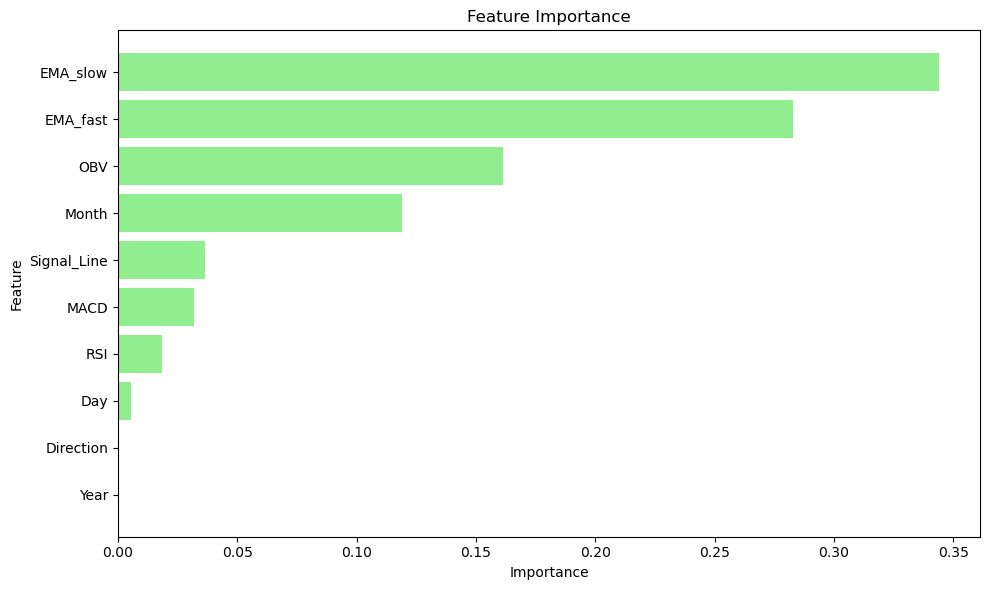

       Feature  Importance
2     EMA_slow    0.343982
1     EMA_fast    0.282886
6          OBV    0.161344
8        Month    0.119136
4  Signal_Line    0.036618
3         MACD    0.031687
0          RSI    0.018442
7          Day    0.005562
5    Direction    0.000343
9         Year    0.000000


In [96]:
explain_choices(model)

The plots above display the difficulty of detecting relevant patterns by using important aspects, such as the date.
A few of the metrics above (like RSI, MACD and Signal Line) were not relevant for the `AAPL.csv`, for example.

Because we did not run the code for all 500 files, as suggested, we cannot plot an average feature importance for all files.

However, the rationale is the same: for every single model, it is possible to evaluate how it made every decision, simply by running the function above.

### Impact of Missclassifications and its Potential Reasons


The impact of missclassification is quite clear: investors fail to obtain a risk-adjusted return.

The incorrect use of the tool could lead to very serious financial issues, hence why we always reinforce the statement that **our program is a tool, meant to be used as another point of in the decision of an experienced stock market analyst**.


We believe that the model's incapability of detecting time sequence based patters severely affected its permance. Although relative price change patterns are being correctly detected, the actual absolute prices simply are not there.


For a more in-depth analysis of this topic, please refer to our **ethics file**.

# Conclusion

Random Forest Regressor was meant to produce buy signals, in order to have a comparison element with the LSTM.

Essentialy, this would be an extra for the project. Unfortunately, we were not able to obtain results we were satisfied with, therefore we will not waste more time than we already have developing such a complex solution to the problem.

Although the professor suggested our model would be capable of extrapolating, external pressures such as the overwhelming ammount of projects and tests scheduled for this delivery week hindered our ability to calmly and timely approach this problem. 

Due to these factors, we still implemented many different ways of mitigating complications we found along the way. When comparing to other groups' projects whose RMSE's were far superior, we noticed and informed them that they were **violating the causality principle**, hence why our results were much inferior. These solutions include:

 - Using MinMax scaling, in order to verify if patterns were correctly detected
 - Using binning to facilitate model training and testing, due to the elevated number of different values for each column
 - Extracted financial metrics and predicting them in order to completely bypass the violation of causality principle
 - Optimized RF parameters
 - Concatenated every Stock data file, using new columns to represent 'Tickers' and 'Sectors', as we were told large ammounts of data allowed for extrapolation
 - Used LightGBM in order to improve training speed (later removed due to feature importance issues)
 - Determined Feature Importance and explained RF's decisions and why they were outputting such results

Despite this, we were able to correctly identify relative changes in price, meaning our model is capable of correctly detecting price changes, while respecting correct prediction principles.